In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import pickle
from tqdm import tqdm


In [3]:
filepath = 'list_of_sentences'

In [4]:
#storing file content into list
preprocessed_text = []
with open(filepath) as fp:
    line = fp.readline()
    while line:
        preprocessed_text.append(line.lower().strip())
        line = fp.readline()

In [5]:
preprocessed_text

['good morning',
 'how are you doing ?',
 'the weather is awesome today',
 'samsung',
 'good afternoon',
 'baseball is played in the usa',
 'there is a thunderstorm',
 'are you doing good ?',
 'the polar regions are melting"',
 'apple',
 'nokia',
 'cricket is a fun game',
 'the climate change is a problem']

## Using Pretrained Models: Avg W2V

In [58]:

# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('D:/AppliedAI/Assignments_DonorsChoose_2018-20190209T070947Z-001/Assignments_DonorsChoose_2018/glove.42B.300d/glove.42B.300d.txt')


Loading Glove Model


1917495it [03:03, 10446.84it/s]


Done. 1917495  words loaded!


In [63]:
words = []
for i in preprocessed_text:
    words.extend(i.split(' '))

print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)

all the words in the coupus 48
the unique words in the coupus 32
The number of words that are present in both glove vectors and our coupus 31 ( 96.875 %)
word 2 vec length 31


## Since we are getting around 97% common words in both our dataset and corpus , so we can use glove vectors.

In [64]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_text): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<?, ?it/s]


13
300


### AvgW2V

In [65]:
avg_w2v_vectors

[array([-8.94720000e-02,  8.28850000e-02, -4.43125000e-02, -1.55998000e-01,
        -5.04850000e-02,  4.10500000e-02, -3.25845000e+00,  3.64330000e-02,
        -3.41365000e-01, -6.76550000e-01,  5.82440000e-02, -5.65150000e-03,
         3.42700000e-02,  9.95400000e-02, -1.70466000e-01, -3.55100000e-02,
         3.02811000e-02,  1.36010000e-01, -2.04635000e-01,  7.54000000e-03,
         2.83200000e-02, -3.15255000e-01,  1.84774500e-01, -2.95929000e-01,
        -2.50945000e-01, -2.43094000e-01, -3.13895000e-01,  5.84070000e-02,
         1.45800500e-01,  1.27588500e-01, -9.19365000e-03,  2.43295000e-01,
         1.95829500e-01,  3.37800000e-02,  2.14375000e-01,  2.69590000e-02,
         1.70950000e-02, -1.96310000e-01, -9.45800000e-03,  1.08915000e-02,
         1.60920500e-01,  5.13395000e-01,  1.76700000e-02, -3.84985000e-01,
         7.96190000e-02, -6.83150000e-02,  1.59883000e-01, -3.55508500e-01,
        -6.61500000e-03, -4.40500000e-03, -1.43615000e-01,  5.80700000e-02,
        -3.3

##  Apply KMeans

In [69]:
from sklearn.cluster import KMeans

k_values = [2,3,4,5]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(avg_w2v_vectors)
    loss.append(kmeans.inertia_)

In [70]:
import matplotlib.pyplot as plt

## Plotting K values v/s loss

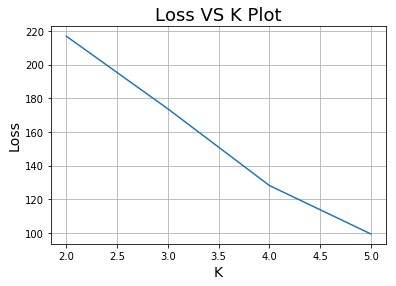

In [71]:
plt.plot(k_values,loss)
plt.xlabel('K',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K Plot',size=18)
plt.grid()
plt.show()

### Since we are getting elbow point at k=4 in the above plot, therefore we will be using k=4

In [72]:
optimal_k = 4#come from plot

kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(avg_w2v_vectors)

In [73]:
kmeans.labels_

array([1, 1, 1, 0, 1, 1, 3, 1, 1, 2, 0, 1, 1])

In [74]:
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(preprocessed_text[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(preprocessed_text[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(preprocessed_text[i])
    elif  kmeans.labels_[i] == 3:
        cluster4.append(preprocessed_text[i])


In [75]:
for i in range(len(cluster1)):
    print('%s\n'%(cluster1[i]))

samsung

nokia



In [76]:
for i in range(len(cluster2)):
    print('%s\n'%(cluster2[i]))

good morning

how are you doing ?

the weather is awesome today

good afternoon

baseball is played in the usa

are you doing good ?

the polar regions are melting"

cricket is a fun game

the climate change is a problem



In [77]:
for i in range(len(cluster3)):
    print('%s\n'%(cluster3[i]))

apple



In [78]:
for i in range(len(cluster4)):
    print('%s\n'%(cluster4[i]))

there is a thunderstorm



## Apply Agglomerative Clustering

In [79]:
from sklearn.cluster import AgglomerativeClustering

aggcl=AgglomerativeClustering(n_clusters=4).fit(avg_w2v_vectors)

In [80]:
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

for i in range(aggcl.labels_.shape[0]):
    if aggcl.labels_[i] == 0:
        cluster1.append(preprocessed_text[i])
    elif aggcl.labels_[i] == 1:
        cluster2.append(preprocessed_text[i])
    elif aggcl.labels_[i] == 2:
        cluster3.append(preprocessed_text[i])
    elif  aggcl.labels_[i] == 3:
        cluster4.append(preprocessed_text[i])


In [81]:
for i in range(len(cluster1)):
    print('%s\n'%(cluster1[i]))

good morning

how are you doing ?

the weather is awesome today

good afternoon

baseball is played in the usa

are you doing good ?

the polar regions are melting"

cricket is a fun game

the climate change is a problem



In [82]:
for i in range(len(cluster2)):
    print('%s\n'%(cluster2[i]))

samsung

nokia



In [83]:
for i in range(len(cluster3)):
    print('%s\n'%(cluster3[i]))

there is a thunderstorm



In [84]:
for i in range(len(cluster4)):
    print('%s\n'%(cluster4[i]))

apple



## Since the dataset is very less that is why model is not performing well .